In [1]:
! pip install evaluate
! pip install -U datasets
! pip install -U nltk
! pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.8 MB/s eta 0:00:0000:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=c7f7c8b8579285df09006f39a499f3cee8c0ff70d8d77cc790

In [2]:
import os
from pathlib import Path
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForConditionalGeneration, get_cosine_schedule_with_warmup
import requests
from datasets import load_from_disk
from accelerate import Accelerator
import torch
import spacy
import re
import json
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import random
from evaluate import load
import torch
from torch.nn import functional as nnf
from PIL import Image
import numpy as np
from tqdm import tqdm


# set all seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
MODEL_NAME = "microsoft/git-base"
PROCESSOR = AutoProcessor.from_pretrained(MODEL_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
OUTPUT_DIR = "microsoft_git-base_artgraph"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8 # choose according to your GPU memory (<= 64) we'll use gradient accumulation
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL.to(DEVICE)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [5]:
DATASET = load_from_disk("/kaggle/input/captioning-dataset-augmented-processed/captioning_dataset_augmented_processed")

In [6]:
# on the fly image augmentation
augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=10),
])

def _transform_train(example_batch):
    images = [augment(x) for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]
    inputs = PROCESSOR(images=images, text=captions, padding="max_length", return_tensors="pt")
    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs

def _transform_test(example_batch):
    # just compute the input_ids for all captions in example
    images = [x for x in example_batch["image"]]
    captions_list = [x for x in example_batch["captions"]]
    clip_scores = torch.tensor([x for x in example_batch["clip_score"]])
    file_names = [x for x in example_batch["file_name"]]
    inputs_list = [
        PROCESSOR(images=image, text=captions, padding="max_length", return_tensors="pt")
        for image, captions in zip(images, captions_list)
    ]
    # from list of dicts to dict of lists
    inputs = {}
    for k in inputs_list[0].keys():
        inputs[k] = [x[k] if k != "pixel_values" else x[k].squeeze() for x in inputs_list]

    inputs.update({
        "clip_score": clip_scores,
        "file_name": file_names
    })
    return inputs

DATASET["train"].set_transform(_transform_train)
DATASET["validation"].set_transform(_transform_test)

In [7]:
train_dataloader = DataLoader(DATASET["train"], batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(DATASET["validation"], batch_size=BATCH_SIZE)

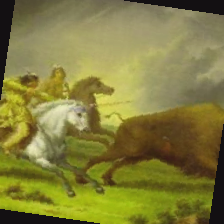

In [8]:
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (DATASET["train"][0]["pixel_values"].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [9]:
print(MODEL.generation_config)

GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 101,
  "eos_token_id": 102,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}



In [10]:
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

@torch.no_grad()
def compute_metrics():
    all_decoded_predictions, all_decoded_labels = [], []
    for batch in tqdm(valid_dataloader):
        labels = batch.pop("input_ids").to(DEVICE)
        pixel_values = batch.pop("pixel_values").to(DEVICE)

        generated_ids = MODEL.generate(pixel_values=pixel_values, max_length=50)
        decoded_labels = []
        for label_group in labels:
            decoded_labels.append(PROCESSOR.batch_decode(label_group, skip_special_tokens=True))
        decoded_predictions = PROCESSOR.batch_decode(generated_ids, skip_special_tokens=True)

        all_decoded_labels += decoded_labels
        all_decoded_predictions += decoded_predictions

    bleu1_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels, max_order=1)
    bleu4_score = bleu.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    rouge_score = rouge.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    meteor_score = meteor.compute(predictions=all_decoded_predictions, references=all_decoded_labels)
    return {
        "bleu1_score": bleu1_score,
        "bleu4_score": bleu4_score,
        "rouge_score": rouge_score,
        "meteor_score": meteor_score
    }

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [11]:
EPOCHS = 5
IDEAL_BATCH_SIZE = 64
GRADIENT_ACCUMULATION_STEPS = IDEAL_BATCH_SIZE // BATCH_SIZE
optimizer = torch.optim.AdamW(MODEL.parameters(), lr=4.5e-7)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=(len(DATASET["train"]) // IDEAL_BATCH_SIZE) * EPOCHS)
epoch = 0

In [16]:
# checkpoint = torch.load("/kaggle/working/microsoft_git-base_artgraph/2.pt", map_location=torch.device("cpu"))
# MODEL.load_state_dict(checkpoint["model_state_dict"])
# MODEL.to(DEVICE)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
# epoch = checkpoint["epoch"] + 1

num_image_tokens = MODEL.git.encoder.layer[0].attention.self.image_patch_tokens

In [12]:
epoch

0

In [14]:
for param in MODEL.git.image_encoder.parameters():
    param.requires_grad = False
for param in MODEL.git.embeddings.parameters():
    param.requires_grad = False

In [ ]:
while epoch < EPOCHS:
  MODEL.train(True)
  print("Epoch:", epoch)
  running_loss = 0.0
  for step, batch in enumerate(tqdm(train_dataloader), start=1):
    input_ids = batch.pop("input_ids").to(DEVICE)
    labels = input_ids
    pixel_values = batch.pop("pixel_values").to(DEVICE)
    attention_mask = batch.pop("attention_mask").to(DEVICE)
    clip_weights = batch.pop("clip_score").to(DEVICE)
    clip_weights = (clip_weights * 8) - 1/5

    outputs = MODEL(input_ids=input_ids,
                    pixel_values=pixel_values,
                    attention_mask=attention_mask)
    logits = outputs.logits

    # weighted loss
    shifted_logits = logits[:, num_image_tokens:-1, :].contiguous()
    labels = labels[:, 1:].contiguous()
    shifted_logits = shifted_logits.permute(0, 2, 1)
    losses = nnf.cross_entropy(shifted_logits, labels, ignore_index=0, reduction="none")
    losses = losses.sum(dim=1) / (labels != 0).sum(dim=1)
    weighted_losses = losses * clip_weights
    loss = weighted_losses.mean() / GRADIENT_ACCUMULATION_STEPS
    running_loss += loss.item()

    # accelerator.backward(loss)
    loss.backward()

    if step % GRADIENT_ACCUMULATION_STEPS == 0:
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
  
  MODEL.train(False)
  avg_loss = running_loss / (len(DATASET["train"]) // IDEAL_BATCH_SIZE)
  print("Loss:", avg_loss)
  torch.save({
        'epoch': epoch,
        'model_state_dict': MODEL.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
  }, os.path.join(OUTPUT_DIR, f"{epoch}.pt"))
  metrics = compute_metrics()
  metrics["loss"] = avg_loss
  with open(os.path.join(OUTPUT_DIR, f"{epoch}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
  epoch += 1

Epoch: 0


100%|██████████| 30048/30048 [4:45:27<00:00,  1.75it/s]  


Loss: 6.447991377916857


100%|██████████| 2141/2141 [1:20:09<00:00,  2.25s/it]


Epoch: 1


100%|██████████| 30048/30048 [4:45:19<00:00,  1.76it/s]  


Loss: 5.896478794314731


 78%|███████▊  | 1678/2141 [1:01:33<19:44,  2.56s/it]